### 1.0 Inicialización y carga de datos

In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st
from joblib import dump
from matplotlib import pyplot
import random
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
pip install lightgbm

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

C:\Users\festu\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [7]:
df_sell_in_01 = pd.read_csv('/Users/festu/OneDrive/Documentos/WORKING MINDS/PPG COMEX/Consolidado Sell In/Consolidado_SellIn_01.csv',index_col=0, encoding='latin-1')
df_sell_in_02 = pd.read_csv('/Users/festu/OneDrive/Documentos/WORKING MINDS/PPG COMEX/Consolidado Sell In/Consolidado_SellIn_02.csv',index_col=0, encoding='latin-1')                

In [8]:
df_sell_in_01.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507236 entries, 2024 to 2024
Data columns (total 9 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Mes                                      507236 non-null  object 
 1   Familias                                 507236 non-null  object 
 2   Divisiones                               507236 non-null  object 
 3   Regiones                                 507236 non-null  object 
 4   Territorios                              507236 non-null  object 
 5   Cuentas                                  507236 non-null  object 
 6   SKU / Item Desc                          507236 non-null  object 
 7        1.1-Venta Bruta                     507236 non-null  float64
 8        1.1-Venta Bruta Cantidad en Piezas  507236 non-null  float64
dtypes: float64(2), object(7)
memory usage: 38.7+ MB


In [9]:
df_sell_in_02.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048573 entries, A2023 to A2023
Data columns (total 9 columns):
 #   Column                                   Non-Null Count    Dtype  
---  ------                                   --------------    -----  
 0   Mes Desc                                 1048573 non-null  object 
 1   Familias                                 1048573 non-null  object 
 2   Divisiones                               1048573 non-null  object 
 3   Regiones                                 1048573 non-null  object 
 4   Territorios                              1048573 non-null  object 
 5   Cuentas                                  1048573 non-null  object 
 6   SKU / Item Desc                          1048573 non-null  object 
 7        1.1-Venta Bruta                     1048573 non-null  float64
 8        1.1-Venta Bruta Cantidad en Piezas  1048573 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 80.0+ MB


### 2.0 Preprocesamiento de datos

In [11]:
df_sell_in_01.rename(columns={'     1.1-Venta Bruta':'venta_bruta', '     1.1-Venta Bruta Cantidad en Piezas':'piezas','SKU / Item Desc':'SKU'}, inplace=True)
df_sell_in_02.rename(columns={'Mes Desc':'Mes','     1.1-Venta Bruta':'venta_bruta', '     1.1-Venta Bruta Cantidad en Piezas':'piezas','SKU / Item Desc':'SKU'}, inplace=True)

In [12]:
df_sell_in_01.columns = [col.lower() for col in df_sell_in_01.columns]
df_sell_in_02.columns = [col.lower() for col in df_sell_in_02.columns]

In [13]:
df_sell_in = pd.concat([df_sell_in_01, df_sell_in_02])

In [14]:
# Define a custom function to map month names to integers
def month_to_int(month_name):
    month_map = {
        'Enero': 1,
        'Febrero': 2,
        'Marzo': 3,
        'Octubre':10,
        'Noviembre':11,
        'Diciembre':12
        # Add more months as needed
    }
    return month_map.get(month_name)

In [15]:
# Apply the custom function to the 'date' column
df_sell_in['mes'] = df_sell_in['mes'].apply(month_to_int)

In [16]:
df_sell_in = df_sell_in.reset_index().rename(columns={'index':'año'})

In [17]:
df_sell_in['año'] = df_sell_in['año'].replace({'A2023': '2023'})

In [18]:
df_sell_in['año'] = df_sell_in['año'].astype('int64')
df_sell_in['mes'] = df_sell_in['mes'].astype('int64')

In [19]:
df_sell_in['fecha'] = pd.to_datetime(df_sell_in['mes'].astype(str) + '/' + df_sell_in['año'].astype(str), format='%m/%Y')
df_sell_in['fecha'] = df_sell_in['fecha'].dt.to_period('M')

In [20]:
# Display the dataframe with month names changed to integers
df_sell_in = df_sell_in.drop(['mes', 'año'], axis=1)

In [21]:
# Desired column order
new_order = ['fecha', 'familias', 'divisiones', 'regiones', 'territorios', 'cuentas','sku','venta_bruta','piezas']

# Reordering the columns
df_sell_in = df_sell_in[new_order]

In [22]:
df_sell_in.isna().sum()

fecha          0
familias       0
divisiones     0
regiones       0
territorios    0
cuentas        0
sku            0
venta_bruta    0
piezas         0
dtype: int64

In [23]:
df_sell_in.head()

,fecha,familias,divisiones,regiones,territorios,cuentas,sku,venta_bruta,piezas
0,2024-01,50001-ESMALTES,1-FRONTERA PACIFICO,10-FRONTERA OESTE,1002-MEXICALI,107-00020240-CENTRO DE PINTURAS COMEX ENSENADA SA,19A0004709-KIT SKETCH PLUMON II,1585.10,2.0
1,2024-01,50001-ESMALTES,1-FRONTERA PACIFICO,10-FRONTERA OESTE,1002-MEXICALI,107-00020240-CENTRO DE PINTURAS COMEX ENSENADA SA,19A0200968-VELMAR NF CAFE,0.00,0.0
2,2024-01,50001-ESMALTES,1-FRONTERA PACIFICO,10-FRONTERA OESTE,1002-MEXICALI,107-00020240-CENTRO DE PINTURAS COMEX ENSENADA SA,19A0200979-VELMAR NF V1,17223.84,9.0
3,2024-01,50001-ESMALTES,1-FRONTERA PACIFICO,10-FRONTERA OESTE,1002-MEXICALI,107-00020240-CENTRO DE PINTURAS COMEX ENSENADA SA,19A0203321-FLASH COAT NF BLANCO,7999.98,3.0
4,2024-01,50001-ESMALTES,1-FRONTERA PACIFICO,10-FRONTERA OESTE,1002-MEXICALI,107-00020240-CENTRO DE PINTURAS COMEX ENSENADA SA,19A0203347-FLASH COAT NF VIVID B2,2502.77,1.0


### 3.0 Análisis exploratorio de datos I - Venta Bruta

#### 3.1 Venta bruta por familia

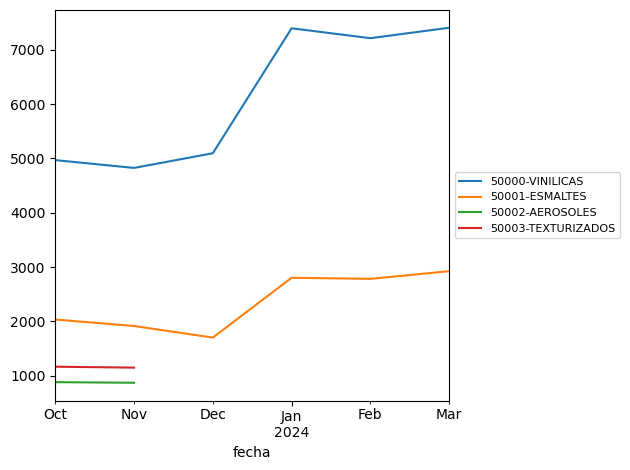

In [26]:
df_pivot_table_1 = df_sell_in.pivot_table(values='venta_bruta', columns = 'familias', index = 'fecha')
df_pivot_table_1.plot()
plt.legend(fontsize="8", loc ="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

#### 3.2 Venta bruta por división

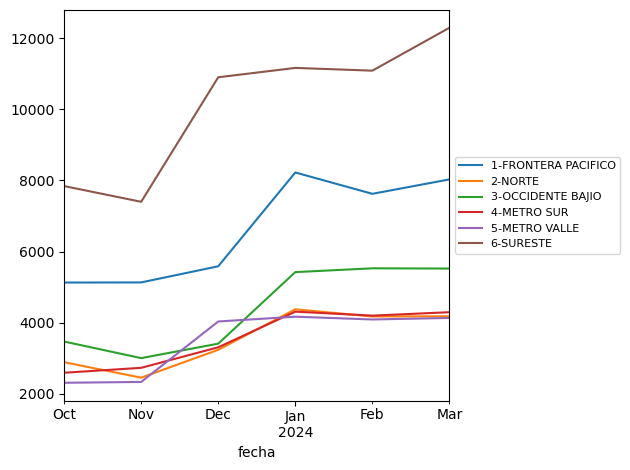

In [28]:
df_pivot_table_2 = df_sell_in.pivot_table(values='venta_bruta', columns = 'divisiones', index = 'fecha')
df_pivot_table_2.plot()
plt.legend(fontsize="8", loc ="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

#### 3.3 Venta bruta por región

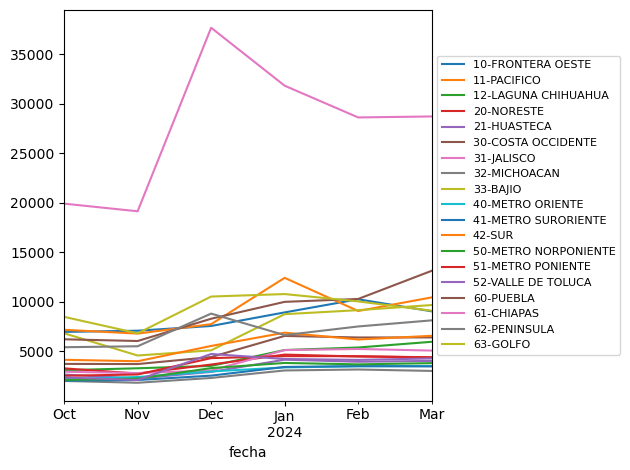

In [30]:
df_pivot_table_3 = df_sell_in.pivot_table(values='venta_bruta', columns = 'regiones', index = 'fecha')
df_pivot_table_3.plot()
plt.legend(fontsize="8", loc ="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

#### 3.4 Venta bruta por territorio

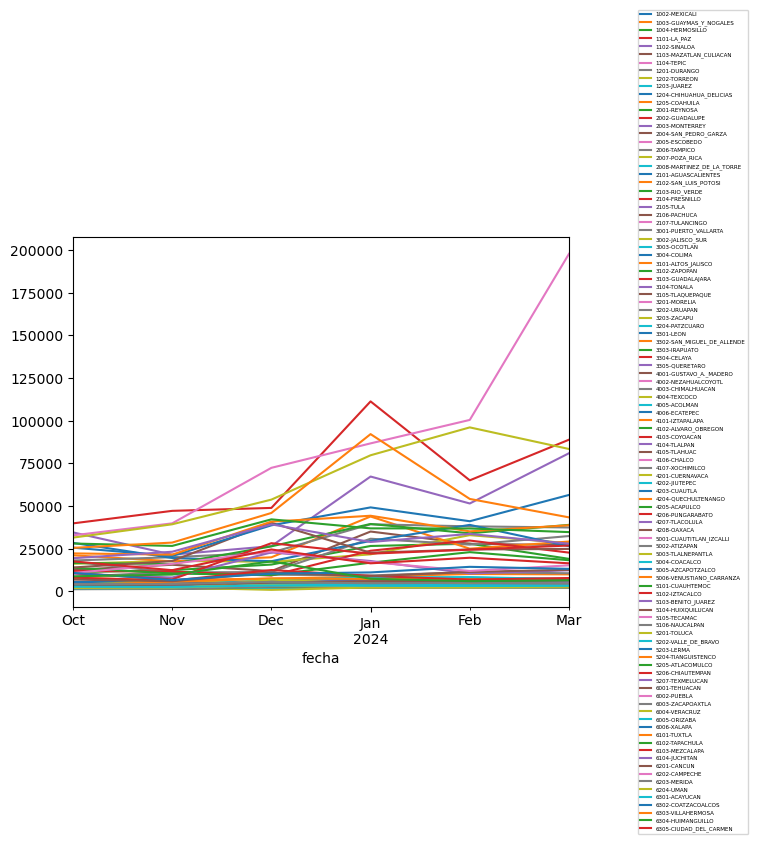

In [32]:
df_pivot_table_4 = df_sell_in.pivot_table(values='venta_bruta', columns = 'territorios', index = 'fecha')
df_pivot_table_4.plot()
plt.legend(fontsize="4", loc ="center", bbox_to_anchor=(1.25, 0.5))
plt.show()

#### 3.5 Venta bruta por cuenta

In [34]:
df_pivot_table_5 = df_sell_in.pivot_table(values='venta_bruta', columns = ['divisiones','cuentas'], index = 'fecha').sort_values(by='fecha').reset_index()

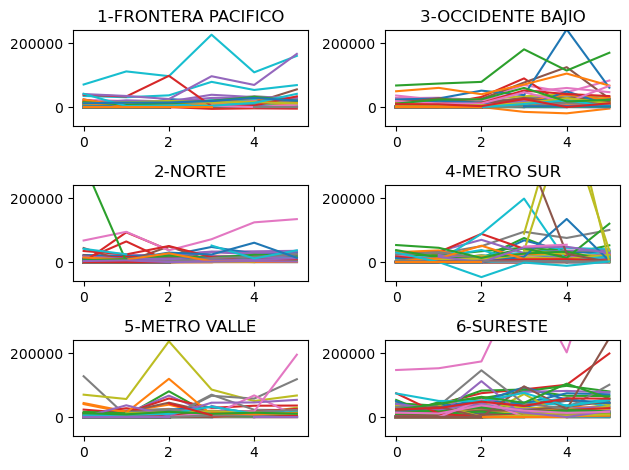

In [35]:
fig, axs = plt.subplots(3, 2)

axs[0, 0].plot(df_pivot_table_5.index, df_pivot_table_5['1-FRONTERA PACIFICO'].values)
axs[0, 0].set_title("1-FRONTERA PACIFICO")
axs[1, 0].plot(df_pivot_table_5.index, df_pivot_table_5['2-NORTE'].values)
axs[1, 0].set_title("2-NORTE")
axs[0, 1].plot(df_pivot_table_5.index, df_pivot_table_5['3-OCCIDENTE BAJIO'].values)
axs[0, 1].set_title("3-OCCIDENTE BAJIO")
axs[1, 1].plot(df_pivot_table_5.index, df_pivot_table_5['4-METRO SUR'].values)
axs[1, 1].set_title("4-METRO SUR")
axs[2, 0].plot(df_pivot_table_5.index, df_pivot_table_5['5-METRO VALLE'].values)
axs[2, 0].set_title("5-METRO VALLE")
axs[2, 1].plot(df_pivot_table_5.index, df_pivot_table_5['6-SURESTE'].values)
axs[2, 1].set_title("6-SURESTE")

axs[1, 0].sharex(axs[0, 0])
axs[2, 0].sharex(axs[0, 0])
axs[0, 1].sharex(axs[0, 0])
axs[1, 1].sharex(axs[0, 0])
axs[2, 1].sharex(axs[0, 0])
                                  
axs[2, 1].sharey(axs[0,0 ])
axs[1, 0].sharey(axs[0,0 ])
axs[0, 1].sharey(axs[0,0 ])
axs[1, 1].sharey(axs[0,0 ])
axs[2, 0].sharey(axs[0,0 ])

fig.tight_layout()
plt.show()

#### 3.6 Venta bruta por mes

In [37]:
pivot_div_fecha = df_sell_in.pivot_table(values='venta_bruta', columns = 'divisiones', index = 'fecha', aggfunc = 'sum').reset_index()

In [38]:
pivot_div_fecha

divisiones,fecha,1-FRONTERA PACIFICO,2-NORTE,3-OCCIDENTE BAJIO,4-METRO SUR,5-METRO VALLE,6-SURESTE
0,2023-10,1.226276e+08,1.586638e+08,2.022901e+08,2.908828e+08,2.508610e+08,2.926409e+08
1,2023-11,1.166845e+08,1.270838e+08,1.698411e+08,3.035176e+08,2.375566e+08,2.589663e+08
2,2023-12,1.096565e+08,1.552033e+08,1.563522e+08,2.960429e+08,2.076102e+08,2.025504e+08
3,2024-01,8.030522e+07,1.138137e+08,1.430995e+08,2.063589e+08,1.833692e+08,1.669697e+08
4,2024-02,7.442433e+07,1.086004e+08,1.459113e+08,2.010306e+08,1.799121e+08,1.658235e+08
5,2024-03,7.839867e+07,1.087346e+08,1.457507e+08,2.056542e+08,1.818317e+08,1.838577e+08


In [39]:
pivot_fecha_venta = df_sell_in.groupby('fecha')['venta_bruta'].sum().reset_index()
pivot_fecha_venta = pd.DataFrame(pivot_fecha_venta)

In [40]:
pivot_fecha_venta

,fecha,venta_bruta
0,2023-10,1.317966e+09
1,2023-11,1.213650e+09
2,2023-12,1.127415e+09
3,2024-01,8.939163e+08
4,2024-02,8.757023e+08
5,2024-03,9.042276e+08


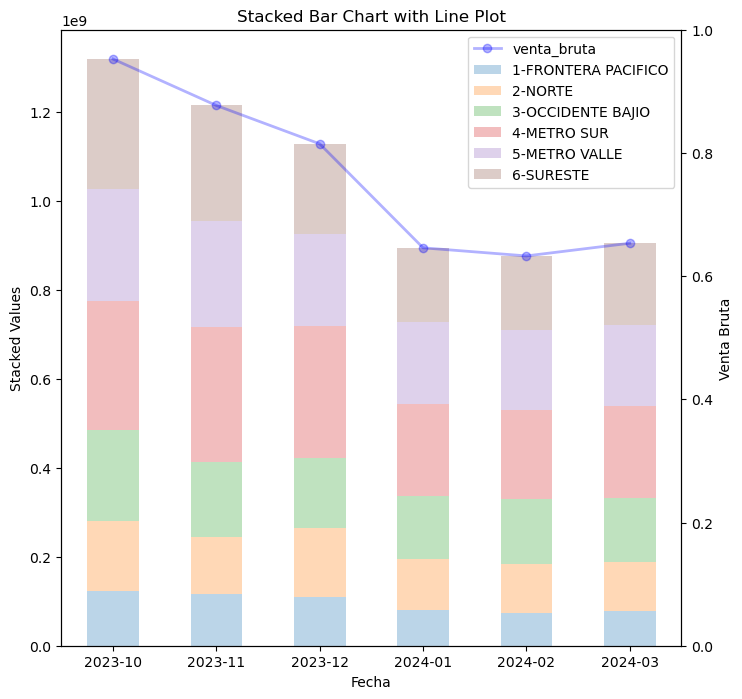

In [41]:
fig, ax1 = plt.subplots(figsize=(8, 8))


pivot_div_fecha.plot(ax=ax1, kind='bar', stacked=True,  alpha=0.3)
ax2 = ax1.twinx()
pivot_fecha_venta.plot(ax=ax1, color='blue', marker='o', linewidth=2, label='Suma Venta Bruta', alpha=0.3)

# Set y-axis limits for the secondary axis
#min_y = df_sell_in['venta_bruta'].min() * 0.8  # For example, 80% of the minimum value
#max_y = df_sell_in['venta_bruta'].max() * 1.2  # 120% of the maximum value
#ax2.set_ylim([min_y, max_y])

ax1.set_xlabel('Fecha')
ax1.set_ylabel('Stacked Values')
ax2.set_ylabel('Venta Bruta')

plt.title('Stacked Bar Chart with Line Plot')
ax1.legend(loc='upper right')


ax1.set_xticklabels(labels = ['2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03'])

plt.show()

### 4.0 Análisis exploratorio de datos II - Desglose de venta bruta


#### 4.1 Principales territorios por división

In [44]:
terr_frontera = df_sell_in[df_sell_in['divisiones']=='1-FRONTERA PACIFICO'].groupby('territorios').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False)
terr_norte = df_sell_in[df_sell_in['divisiones']=='2-NORTE'].groupby('territorios').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False)
terr_bajio = df_sell_in[df_sell_in['divisiones']=='3-OCCIDENTE BAJIO'].groupby('territorios').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False)
terr_sur = df_sell_in[df_sell_in['divisiones']=='4-METRO SUR'].groupby('territorios').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False)
terr_valle = df_sell_in[df_sell_in['divisiones']=='5-METRO VALLE'].groupby('territorios').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False)
terr_sureste = df_sell_in[df_sell_in['divisiones']=='6-SURESTE'].groupby('territorios').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False)

In [45]:
terr_frontera["acumulado"] = terr_frontera["venta_bruta"].cumsum()/terr_frontera["venta_bruta"].sum()*100
terr_norte["acumulado"] = terr_norte["venta_bruta"].cumsum()/terr_norte["venta_bruta"].sum()*100
terr_bajio["acumulado"] = terr_bajio["venta_bruta"].cumsum()/terr_bajio["venta_bruta"].sum()*100
terr_sur["acumulado"] = terr_sur["venta_bruta"].cumsum()/terr_sur["venta_bruta"].sum()*100
terr_valle["acumulado"] = terr_valle["venta_bruta"].cumsum()/terr_valle["venta_bruta"].sum()*100
terr_sureste["acumulado"] = terr_sureste["venta_bruta"].cumsum()/terr_sureste["venta_bruta"].sum()*100

C:\Users\festu\AppData\Local\Temp\ipykernel_20512\1682770242.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(terr_frontera.index, rotation=90)
C:\Users\festu\AppData\Local\Temp\ipykernel_20512\1682770242.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(terr_norte.index, rotation=90)
C:\Users\festu\AppData\Local\Temp\ipykernel_20512\1682770242.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(terr_bajio.index, rotation=90)
C:\Users\festu\AppData\Local\Temp\ipykernel_20512\1682770242.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels(terr_sur.index, 

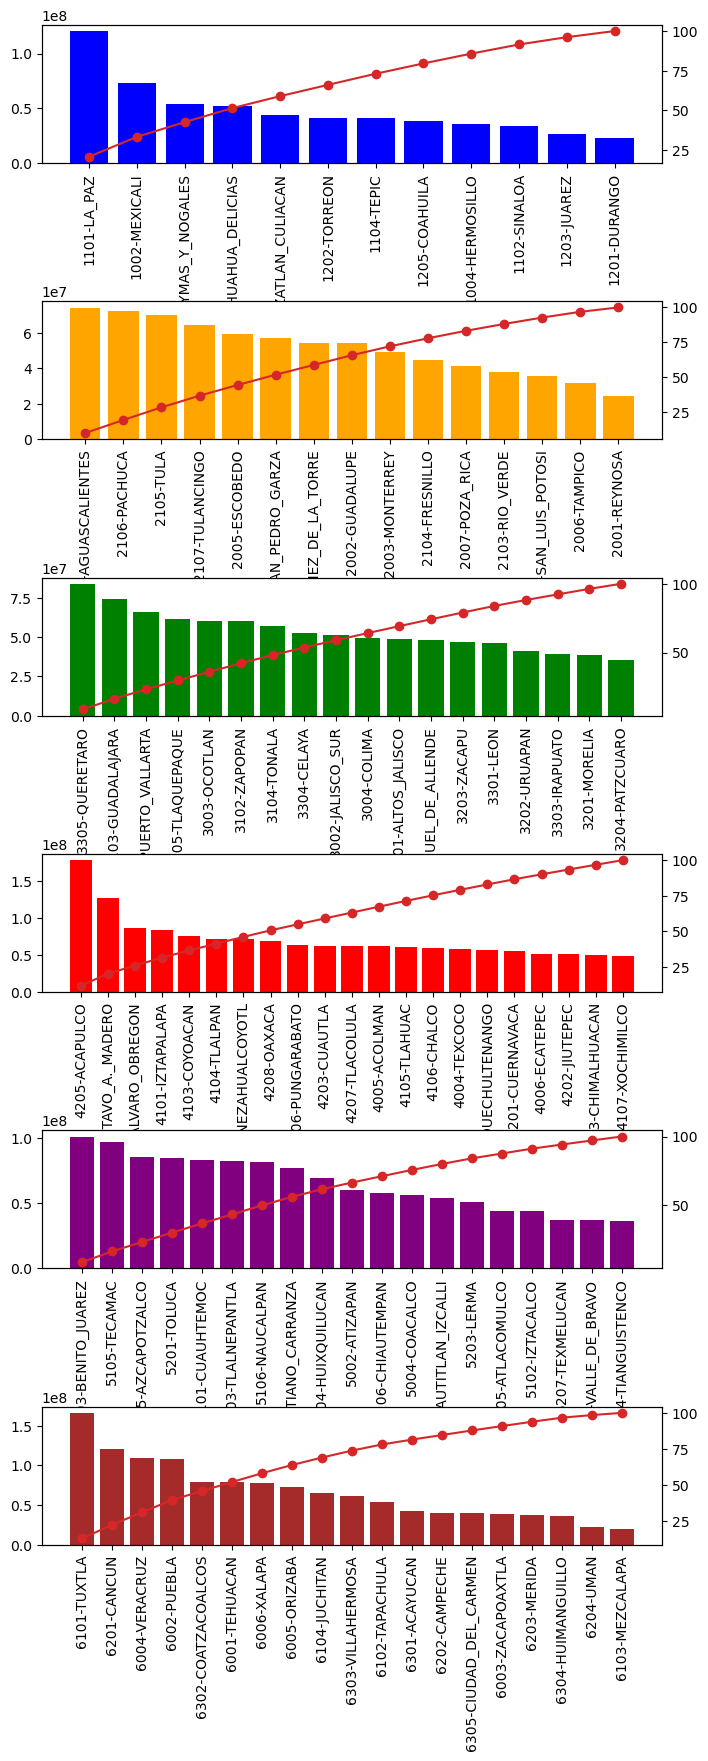

In [46]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(8, 8))


axes[0].bar(terr_frontera.index, terr_frontera['venta_bruta'], color='blue', label='1-FRONTERA PACIFICO')
axes[0].twinx().plot(terr_frontera.index, terr_frontera['acumulado'] ,color='tab:red', marker='o')

axes[1].bar(terr_norte.index, terr_norte['venta_bruta'], color='orange', label='1-FRONTERA PACIFICO')
axes[1].twinx().plot(terr_norte.index, terr_norte['acumulado'] ,color='tab:red', marker='o')

axes[2].bar(terr_bajio.index, terr_bajio['venta_bruta'], color='green', label='1-FRONTERA PACIFICO')
axes[2].twinx().plot(terr_bajio.index, terr_bajio['acumulado'] ,color='tab:red', marker='o')

axes[3].bar(terr_sur.index, terr_sur['venta_bruta'], color='red', label='1-FRONTERA PACIFICO')
axes[3].twinx().plot(terr_sur.index, terr_sur['acumulado'] ,color='tab:red', marker='o')

axes[4].bar(terr_valle.index, terr_valle['venta_bruta'], color='purple', label='1-FRONTERA PACIFICO')
axes[4].twinx().plot(terr_valle.index, terr_valle['acumulado'] ,color='tab:red', marker='o')

axes[5].bar(terr_sureste.index, terr_sureste['venta_bruta'], color='brown', label='1-FRONTERA PACIFICO')
axes[5].twinx().plot(terr_sureste.index, terr_sureste['acumulado'] ,color='tab:red', marker='o')

axes[0].set_xticklabels(terr_frontera.index, rotation=90)
axes[1].set_xticklabels(terr_norte.index, rotation=90)
axes[2].set_xticklabels(terr_bajio.index, rotation=90)
axes[3].set_xticklabels(terr_sur.index, rotation=90)
axes[4].set_xticklabels(terr_valle.index, rotation=90)
axes[5].set_xticklabels(terr_sureste.index, rotation=90)

plt.subplots_adjust(
                    bottom=0.1, 
                    top=2,  
                    hspace=1,
                    )

plt.show()



#### 4.2 Principales cuentas por división

In [48]:
cuentas_frontera = df_sell_in[df_sell_in['divisiones']=='1-FRONTERA PACIFICO'].groupby('cuentas').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)
cuentas_norte = df_sell_in[df_sell_in['divisiones']=='2-NORTE'].groupby('cuentas').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)
cuentas_bajio = df_sell_in[df_sell_in['divisiones']=='3-OCCIDENTE BAJIO'].groupby('cuentas').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)
cuentas_sur = df_sell_in[df_sell_in['divisiones']=='4-METRO SUR'].groupby('cuentas').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)
cuentas_valle = df_sell_in[df_sell_in['divisiones']=='5-METRO VALLE'].groupby('cuentas').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)
cuentas_sureste = df_sell_in[df_sell_in['divisiones']=='6-SURESTE'].groupby('cuentas').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)

In [49]:
cuentas_frontera["acumulado"] = cuentas_frontera["venta_bruta"].cumsum()/cuentas_frontera["venta_bruta"].sum()*100
cuentas_norte["acumulado"] = cuentas_norte["venta_bruta"].cumsum()/cuentas_norte["venta_bruta"].sum()*100
cuentas_bajio["acumulado"] = cuentas_bajio["venta_bruta"].cumsum()/cuentas_bajio["venta_bruta"].sum()*100
cuentas_sur["acumulado"] = cuentas_sur["venta_bruta"].cumsum()/cuentas_sur["venta_bruta"].sum()*100
cuentas_valle["acumulado"] = cuentas_valle["venta_bruta"].cumsum()/cuentas_valle["venta_bruta"].sum()*100
cuentas_sureste["acumulado"] = cuentas_sureste["venta_bruta"].cumsum()/cuentas_sureste["venta_bruta"].sum()*100

C:\Users\festu\AppData\Local\Temp\ipykernel_20512\817982081.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(cuentas_frontera.index, rotation=90)
C:\Users\festu\AppData\Local\Temp\ipykernel_20512\817982081.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(cuentas_norte.index, rotation=90)
C:\Users\festu\AppData\Local\Temp\ipykernel_20512\817982081.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(cuentas_bajio.index, rotation=90)
C:\Users\festu\AppData\Local\Temp\ipykernel_20512\817982081.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels(cuentas_sur

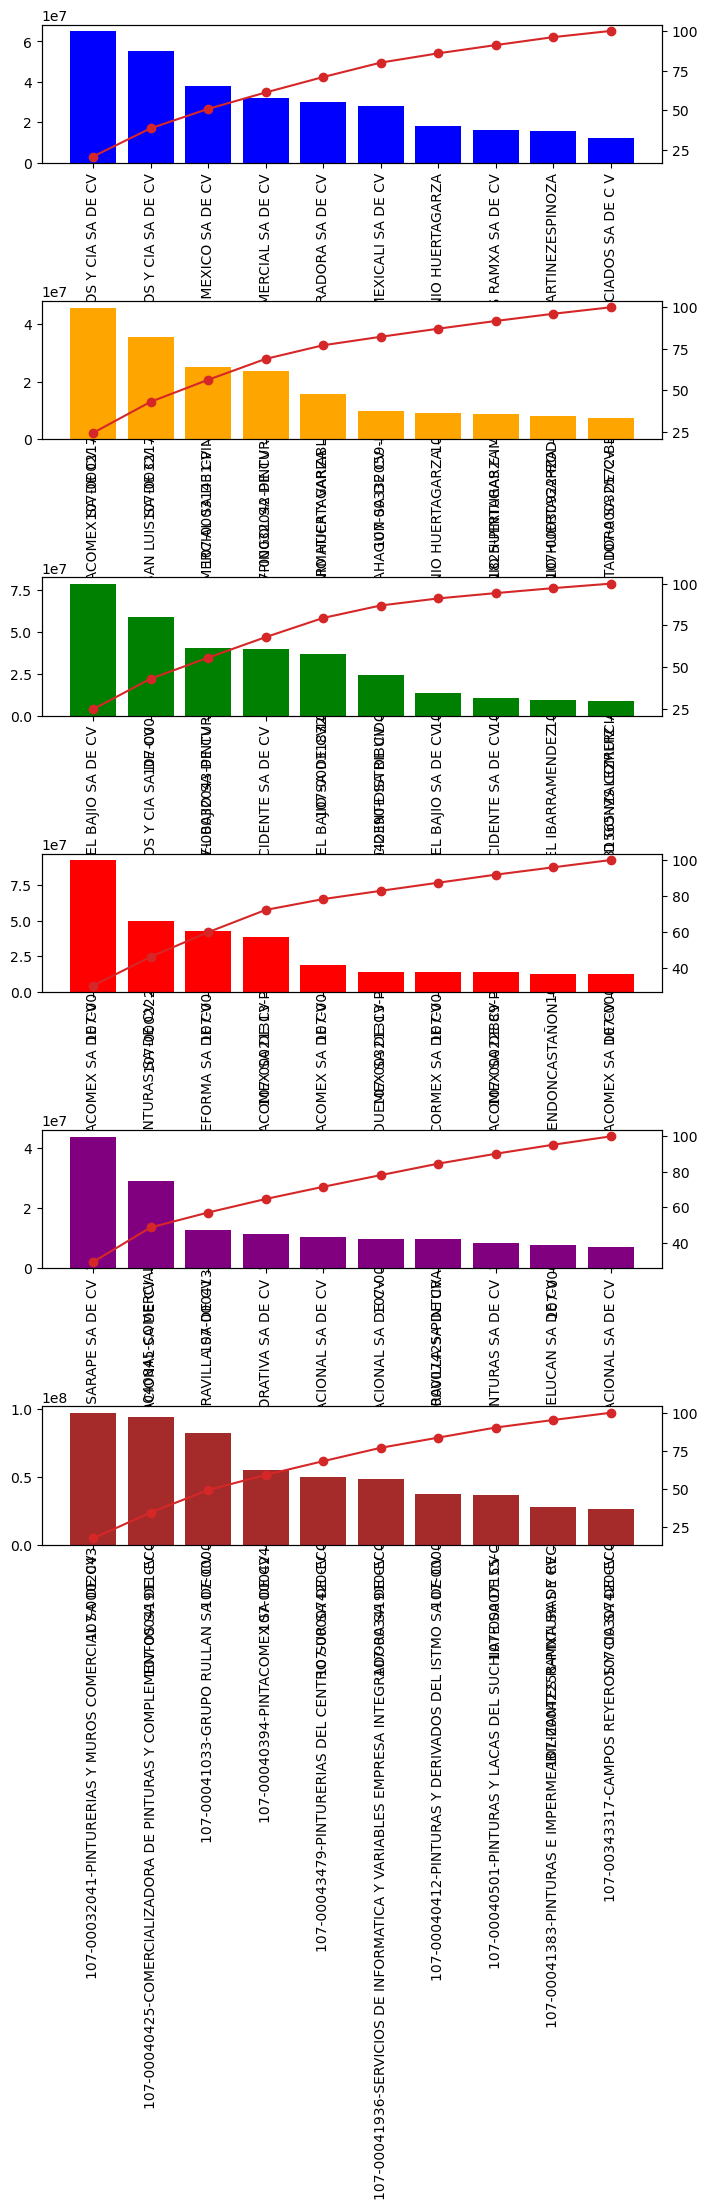

In [50]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(8, 8))


axes[0].bar(cuentas_frontera.index, cuentas_frontera['venta_bruta'], color='blue', label='1-FRONTERA PACIFICO')
axes[0].twinx().plot(cuentas_frontera.index, cuentas_frontera['acumulado'] ,color='tab:red', marker='o')

axes[1].bar(cuentas_norte.index, cuentas_norte['venta_bruta'], color='orange', label='1-FRONTERA PACIFICO')
axes[1].twinx().plot(cuentas_norte.index, cuentas_norte['acumulado'] ,color='tab:red', marker='o')

axes[2].bar(cuentas_bajio.index, cuentas_bajio['venta_bruta'], color='green', label='1-FRONTERA PACIFICO')
axes[2].twinx().plot(cuentas_bajio.index, cuentas_bajio['acumulado'] ,color='tab:red', marker='o')

axes[3].bar(cuentas_sur.index, cuentas_sur['venta_bruta'], color='red', label='1-FRONTERA PACIFICO')
axes[3].twinx().plot(cuentas_sur.index, cuentas_sur['acumulado'] ,color='tab:red', marker='o')

axes[4].bar(cuentas_valle.index, cuentas_valle['venta_bruta'], color='purple', label='1-FRONTERA PACIFICO')
axes[4].twinx().plot(cuentas_valle.index, cuentas_valle['acumulado'] ,color='tab:red', marker='o')

axes[5].bar(cuentas_sureste.index, cuentas_sureste['venta_bruta'], color='brown', label='1-FRONTERA PACIFICO')
axes[5].twinx().plot(cuentas_sureste.index, cuentas_sureste['acumulado'] ,color='tab:red', marker='o')

axes[0].set_xticklabels(cuentas_frontera.index, rotation=90)
axes[1].set_xticklabels(cuentas_norte.index, rotation=90)
axes[2].set_xticklabels(cuentas_bajio.index, rotation=90)
axes[3].set_xticklabels(cuentas_sur.index, rotation=90)
axes[4].set_xticklabels(cuentas_valle.index, rotation=90)
axes[5].set_xticklabels(cuentas_sureste.index, rotation=90)

plt.subplots_adjust(
                    bottom=0.1, 
                    top=2,  
                    hspace=1,
                    )

plt.show()


#### 4.3 Principales SKU por división

In [52]:
sku_frontera = df_sell_in[df_sell_in['divisiones']=='1-FRONTERA PACIFICO'].groupby('sku').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)
sku_norte = df_sell_in[df_sell_in['divisiones']=='2-NORTE'].groupby('sku').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)
sku_bajio = df_sell_in[df_sell_in['divisiones']=='3-OCCIDENTE BAJIO'].groupby('sku').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)
sku_sur = df_sell_in[df_sell_in['divisiones']=='4-METRO SUR'].groupby('sku').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)
sku_valle = df_sell_in[df_sell_in['divisiones']=='5-METRO VALLE'].groupby('sku').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)
sku_sureste = df_sell_in[df_sell_in['divisiones']=='6-SURESTE'].groupby('sku').agg({'venta_bruta':'sum'}).sort_values(by='venta_bruta',ascending=False).head(10)

In [53]:
sku_frontera["acumulado"] = sku_frontera["venta_bruta"].cumsum()/sku_frontera["venta_bruta"].sum()*100
sku_norte["acumulado"] = sku_norte["venta_bruta"].cumsum()/sku_norte["venta_bruta"].sum()*100
sku_bajio["acumulado"] = sku_bajio["venta_bruta"].cumsum()/sku_bajio["venta_bruta"].sum()*100
sku_sur["acumulado"] = sku_sur["venta_bruta"].cumsum()/sku_sur["venta_bruta"].sum()*100
sku_valle["acumulado"] = sku_valle["venta_bruta"].cumsum()/sku_valle["venta_bruta"].sum()*100
sku_sureste["acumulado"] = sku_sureste["venta_bruta"].cumsum()/sku_sureste["venta_bruta"].sum()*100

C:\Users\festu\AppData\Local\Temp\ipykernel_20512\3296910894.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(sku_frontera.index, rotation=90)
C:\Users\festu\AppData\Local\Temp\ipykernel_20512\3296910894.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(sku_norte.index, rotation=90)
C:\Users\festu\AppData\Local\Temp\ipykernel_20512\3296910894.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(sku_bajio.index, rotation=90)
C:\Users\festu\AppData\Local\Temp\ipykernel_20512\3296910894.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels(sku_sur.index, rota

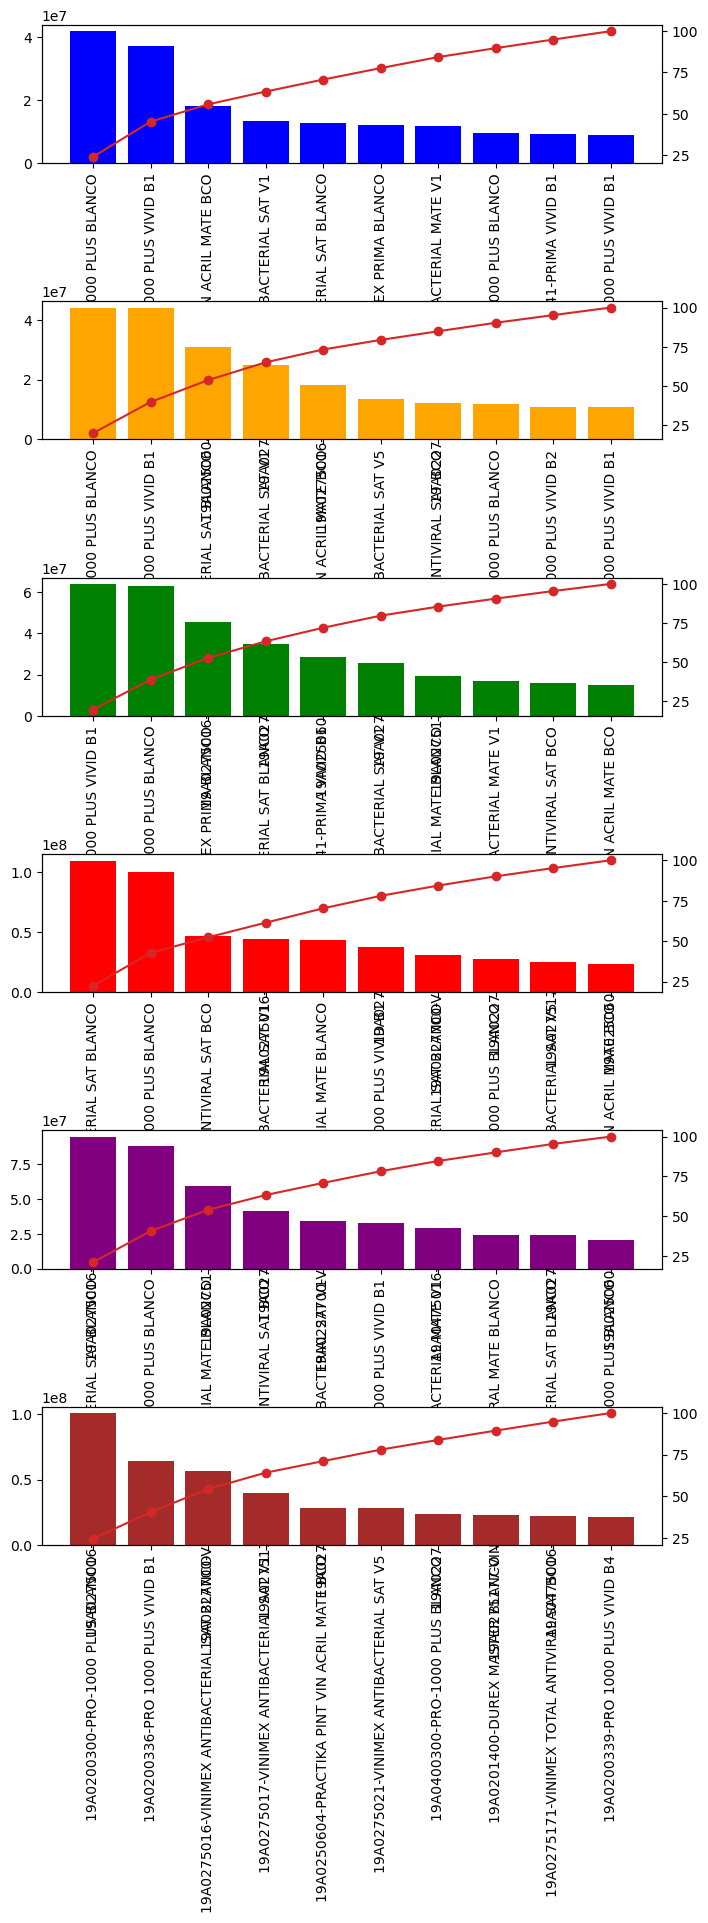

In [54]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(8, 8))


axes[0].bar(sku_frontera.index, sku_frontera['venta_bruta'], color='blue', label='1-FRONTERA PACIFICO')
axes[0].twinx().plot(sku_frontera.index, sku_frontera['acumulado'] ,color='tab:red', marker='o')

axes[1].bar(sku_norte.index, sku_norte['venta_bruta'], color='orange', label='2-NORTE')
axes[1].twinx().plot(sku_norte.index, sku_norte['acumulado'] ,color='tab:red', marker='o')

axes[2].bar(sku_bajio.index, sku_bajio['venta_bruta'], color='green', label='3-OCCIDENTE BAJIO')
axes[2].twinx().plot(sku_bajio.index, sku_bajio['acumulado'] ,color='tab:red', marker='o')

axes[3].bar(sku_sur.index, sku_sur['venta_bruta'], color='red', label='4-METRO SUR')
axes[3].twinx().plot(sku_sur.index, sku_sur['acumulado'] ,color='tab:red', marker='o')

axes[4].bar(sku_valle.index, sku_valle['venta_bruta'], color='purple', label='5-METRO VALLE')
axes[4].twinx().plot(sku_valle.index, sku_valle['acumulado'] ,color='tab:red', marker='o')

axes[5].bar(sku_sureste.index, sku_sureste['venta_bruta'], color='brown', label='6-SURESTE')
axes[5].twinx().plot(sku_sureste.index, sku_sureste['acumulado'] ,color='tab:red', marker='o')

axes[0].set_xticklabels(sku_frontera.index, rotation=90)
axes[1].set_xticklabels(sku_norte.index, rotation=90)
axes[2].set_xticklabels(sku_bajio.index, rotation=90)
axes[3].set_xticklabels(sku_sur.index, rotation=90)
axes[4].set_xticklabels(sku_valle.index, rotation=90)
axes[5].set_xticklabels(sku_sureste.index, rotation=90)

plt.subplots_adjust(
                    bottom=0.1, 
                    top=2,  
                    hspace=1,
                    )

plt.show()


### 5.0 Análisis exploratorio de datos III - Precio vs Unidades


#### 5.1 Distribución de los precios

In [57]:
df_sell_in['precio'] = df_sell_in['venta_bruta'] / df_sell_in['piezas']

In [58]:
price_pivot = df_sell_in.pivot_table(values='precio', columns = ['divisiones'], index = 'sku', aggfunc='median',margins=True).sort_values(by='All',ascending=False).reset_index()

In [59]:
price_pivot

divisiones,sku,1-FRONTERA PACIFICO,2-NORTE,3-OCCIDENTE BAJIO,4-METRO SUR,5-METRO VALLE,6-SURESTE,All
0,19AE046248-FLASH COAT NF = G1-01 CANITO CC,NaN,NaN,NaN,NaN,25203.910,NaN,25203.91
1,19AE046302-FLASH COAT NF = 106 GRIS PERLA CC,NaN,NaN,NaN,NaN,24227.930,NaN,24227.93
2,19A0103365-FLASH COAT NF AMARILLO TOLEDO,NaN,NaN,NaN,24227.93,24796.845,NaN,24227.93
3,19A0103338-FLASH COAT NF NEGRO,NaN,NaN,NaN,24227.93,NaN,NaN,24227.93
4,19A0103321-FLASH COAT NF BLANCO,NaN,21094.54,24227.93,24227.93,25365.760,NaN,24227.93
...,...,...,...,...,...,...,...,...
1085,19A0800906-VELMAR VERDE ESMERALDA,3.93,3.93,3.93,3.93,NaN,3.93,3.93
1086,19A0800928-VELMAR AZUL ELECTRICO,NaN,NaN,NaN,NaN,NaN,3.93,3.93
1087,19A0800913-VELMAR ROJO OXIDO,3.93,3.93,NaN,NaN,3.930,3.93,3.93
1088,19A0800910-VELMAR NARANJA,NaN,3.93,NaN,3.93,3.930,3.93,3.93


In [60]:
price_pivot.describe()

divisiones,1-FRONTERA PACIFICO,2-NORTE,3-OCCIDENTE BAJIO,4-METRO SUR,5-METRO VALLE,6-SURESTE,All
count,822.000000,907.000000,875.000000,914.000000,884.000000,832.000000,1090.000000
mean,733.046454,1079.462957,1015.179891,1341.582247,1492.183258,956.521590,1996.653562
std,1468.174826,2663.456000,2627.192063,3551.802255,3907.377369,2420.605766,4633.811466
min,3.930000,3.930000,3.930000,3.930000,3.930000,3.930000,3.930000
25%,94.714500,92.865714,93.826083,89.771250,91.282500,87.551064,100.615500
50%,322.925000,342.830000,344.436667,350.405000,358.510000,308.330000,406.595000
75%,1069.255000,1275.165000,1120.490000,1324.240000,1329.290000,1082.590000,1576.672500
max,23425.410000,22097.660000,24227.930000,24227.930000,25365.760000,22761.535000,25203.910000


array([[<Axes: title={'center': 'All'}>]], dtype=object)

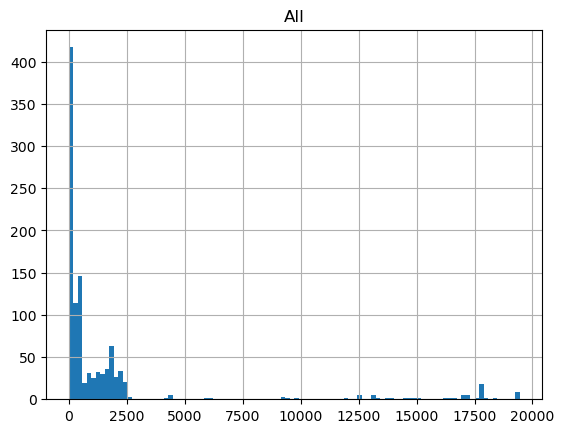

In [61]:
price_pivot.query('All >=0 and All <=20000').hist('All',bins=100)

#### 5.2 Distribución de las unidades vendidas

In [63]:
units_pivot = df_sell_in.pivot_table(values='piezas', columns = ['divisiones'], index = 'sku', aggfunc='sum',margins=True).sort_values(by='All',ascending=False).reset_index()

In [64]:
units_pivot

divisiones,sku,1-FRONTERA PACIFICO,2-NORTE,3-OCCIDENTE BAJIO,4-METRO SUR,5-METRO VALLE,6-SURESTE,All
0,All,1.651365e+06,2204945.0,2478707.0,4221833.0,3201024.0,3555407.0,1.731328e+07
1,19A0400300-PRO-1000 PLUS BLANCO,3.774800e+04,50418.0,58293.0,114483.0,90370.0,93237.0,4.445490e+05
2,19A0600300-PRO-1000 PLUS BLANCO,3.520200e+04,44536.0,47488.0,88774.0,68079.0,76221.0,3.603000e+05
3,19A0675021-VINIMEX ANTIBACTERIAL SAT V5,2.794900e+04,48438.0,41275.0,82178.0,57961.0,87362.0,3.451630e+05
4,19A0200300-PRO-1000 PLUS BLANCO,3.198700e+04,33987.0,47069.0,74635.0,65620.0,75478.0,3.287760e+05
...,...,...,...,...,...,...,...,...
1281,19AE045983-VINIMEX ANT SAT=718 GRIS FRANCES CC,NaN,NaN,NaN,NaN,0.0,NaN,0.000000e+00
1282,19AE045992-COMEX 100 TOTAL = 313-04 CEMENTO CC,NaN,NaN,NaN,NaN,0.0,NaN,0.000000e+00
1283,19A0208273-ACQUA 100 BRILLANTE AZUL INTENSO,NaN,NaN,NaN,0.0,0.0,NaN,0.000000e+00
1284,19AE046037-FLASH COAT NF = 106 GRIS PERLA,NaN,-1.0,NaN,NaN,NaN,NaN,-1.000000e+00


In [65]:
units_pivot.describe()

divisiones,1-FRONTERA PACIFICO,2-NORTE,3-OCCIDENTE BAJIO,4-METRO SUR,5-METRO VALLE,6-SURESTE,All
count,8.670000e+02,9.510000e+02,9.230000e+02,1.013000e+03,9.960000e+02,8.750000e+02,1.286000e+03
mean,3.809377e+03,4.637108e+03,5.370979e+03,8.335307e+03,6.427759e+03,8.126645e+03,2.692579e+04
std,5.618418e+04,7.165486e+04,8.173806e+04,1.329425e+05,1.016662e+05,1.204897e+05,4.839286e+05
min,-3.300000e+01,-1.500000e+01,-2.000000e+00,0.000000e+00,0.000000e+00,-9.000000e+00,-2.000000e+00
25%,4.650000e+01,5.050000e+01,6.250000e+01,4.600000e+01,2.400000e+01,6.500000e+01,1.600000e+01
50%,2.820000e+02,3.430000e+02,4.120000e+02,5.390000e+02,3.445000e+02,6.060000e+02,8.655000e+02
75%,1.691000e+03,1.757000e+03,1.983000e+03,2.832000e+03,1.997000e+03,2.668500e+03,7.715000e+03
max,1.651365e+06,2.204945e+06,2.478707e+06,4.221833e+06,3.201024e+06,3.555407e+06,1.731328e+07


array([[<Axes: title={'center': 'All'}>]], dtype=object)

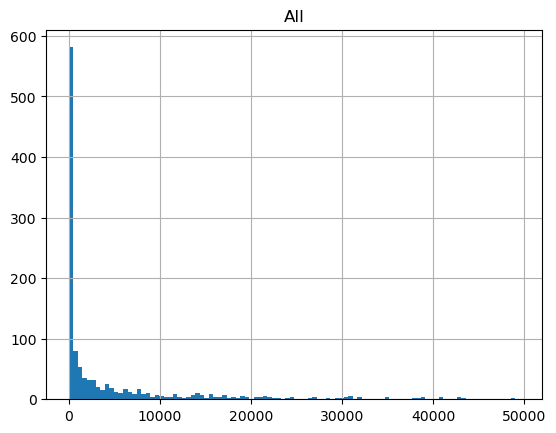

In [66]:
units_pivot.query('All >= 0 and All< 50000').hist('All',bins=100)

#### 5.3 Correlación de precio vs unidades (piezas)

In [68]:
#units_price_pivot = df_sell_in.pivot_table(values=['piezas','precio'], columns = ['sku'], aggfunc='median',margins=True).sort_values(by='All',ascending=False).reset_index()
units_agg = df_sell_in.groupby('sku').agg({'piezas':'sum'})
price_agg = df_sell_in.groupby('sku').agg({'precio':'median'})

In [69]:
units_price_agg = pd.concat([units_agg, price_agg], axis=1, join='inner')

In [70]:
units_price_agg = units_price_agg.dropna()

In [71]:
units_price_agg = units_price_agg.loc[(units_price_agg['precio']<20000)&(units_price_agg['piezas']<=50000)&(units_price_agg['piezas']>0)]

In [72]:
units_price_agg.reset_index()

,sku,piezas,precio
0,19A0004709-KIT SKETCH PLUMON II,3503.0,751.220000
1,19A0100280-COMEX PRIMA BLANCO,45.0,9233.350000
2,19A0100300-PRO-1000 PLUS BLANCO,543.0,12565.930000
3,19A0100318-PRO-1000 PLUS AZUL,1.0,13211.340000
4,19A0100322-PRO-1000 PLUS NEGRO,8.0,12587.055000
...,...,...,...
968,19AM000298-+MT2 SELLO CON COLOR BLANCO,195.0,646.740000
969,19AM001779-+MT2 PINTURA PARA PASTO,513.0,1156.900000
970,19AM001813-+MT2 VIN MATE MAS PODER CUBRIENTE,3202.0,679.992988
971,19AM002191-+MT2 ESMALTE ALQ ECONOMICO BLANCO,17.0,74.880000


In [73]:
units_price_agg.describe()

,piezas,precio
count,973.000000,973.000000
mean,5769.291881,1827.338529
std,9475.624374,4098.510707
min,1.000000,3.930000
25%,126.000000,107.360000
50%,1321.000000,422.360000
75%,6684.000000,1597.470000
max,49510.000000,19453.860000


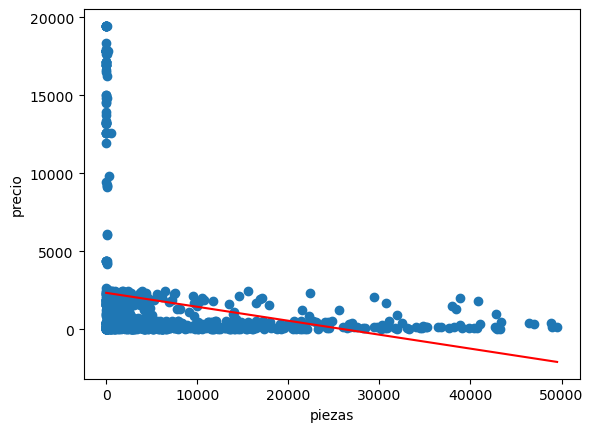

In [74]:
plt.scatter(units_price_agg['piezas'], units_price_agg['precio'])

# fits the best fitting line to the data
plt.plot(np.unique(units_price_agg['piezas']), 
         np.poly1d(np.polyfit(units_price_agg['piezas'], units_price_agg['precio'], 1))
         (np.unique(units_price_agg['piezas'])), color='red')
 
# Labelling axes
plt.xlabel('piezas')
plt.ylabel('precio')

plt.show()

In [75]:
correlation = units_price_agg['precio'].corr(units_price_agg['piezas'])
correlation

-0.20684773240242824

### 6.0 Procesamiento de datos secundario

In [77]:
df_merged = units_price_agg.merge(df_sell_in, how='inner', on='sku')

In [78]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862803 entries, 0 to 862802
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype    
---  ------       --------------   -----    
 0   sku          862803 non-null  object   
 1   piezas_x     862803 non-null  float64  
 2   precio_x     862803 non-null  float64  
 3   fecha        862803 non-null  period[M]
 4   familias     862803 non-null  object   
 5   divisiones   862803 non-null  object   
 6   regiones     862803 non-null  object   
 7   territorios  862803 non-null  object   
 8   cuentas      862803 non-null  object   
 9   venta_bruta  862803 non-null  float64  
 10  piezas_y     862803 non-null  float64  
 11  precio_y     824619 non-null  float64  
dtypes: float64(5), object(6), period[M](1)
memory usage: 79.0+ MB


In [79]:
df_merged.head()

,sku,piezas_x,precio_x,fecha,familias,divisiones,regiones,territorios,cuentas,venta_bruta,piezas_y,precio_y
0,19A0004709-KIT SKETCH PLUMON II,3503.0,751.22,2024-01,50001-ESMALTES,1-FRONTERA PACIFICO,10-FRONTERA OESTE,1002-MEXICALI,107-00020240-CENTRO DE PINTURAS COMEX ENSENADA SA,1585.10,2.0,792.550000
1,19A0004709-KIT SKETCH PLUMON II,3503.0,751.22,2024-01,50001-ESMALTES,1-FRONTERA PACIFICO,10-FRONTERA OESTE,1002-MEXICALI,107-00332059-PINTURAS REM DE MEXICALI SA DE CV,2336.32,3.0,778.773333
2,19A0004709-KIT SKETCH PLUMON II,3503.0,751.22,2024-01,50001-ESMALTES,1-FRONTERA PACIFICO,10-FRONTERA OESTE,1003-GUAYMAS_Y_NOGALES,107-00031771-MANUEL HORACIO BARAJASMENDEZ,792.55,1.0,792.550000
3,19A0004709-KIT SKETCH PLUMON II,3503.0,751.22,2024-01,50001-ESMALTES,1-FRONTERA PACIFICO,11-PACIFICO,1104-TEPIC,107-00022362-PINTURAS DEL 57 SA DE CV,0.00,0.0,NaN
4,19A0004709-KIT SKETCH PLUMON II,3503.0,751.22,2024-01,50001-ESMALTES,1-FRONTERA PACIFICO,12-LAGUNA CHIHUAHUA,1203-JUAREZ,107-00031489-PINTURAS DEL PASO Y JUAREZ SA DE CV,792.55,1.0,792.550000


In [80]:
df_merged['piezas_y'].describe()

count    862803.000000
mean          6.506145
std          23.958409
min        -190.000000
25%           2.000000
50%           3.000000
75%           6.000000
max       14018.000000
Name: piezas_y, dtype: float64

In [81]:
df_merged = df_merged.query('piezas_y >= 0')

In [82]:
df_merged['precio_x'].describe()

count    861771.000000
mean        564.724629
std         829.785118
min           3.930000
25%         107.280000
50%         304.240000
75%         527.000000
max       19453.860000
Name: precio_x, dtype: float64

<Axes: xlabel='fecha'>

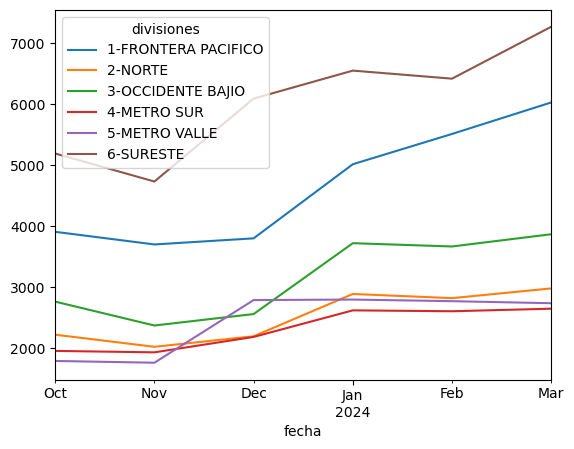

In [83]:
df_merged.pivot_table(values='venta_bruta', columns = 'divisiones', index = 'fecha').plot()

In [84]:
df_merged['año'] = df_merged['fecha'].dt.year
df_merged['mes'] = df_merged['fecha'].dt.month

In [85]:
df_merged.sample()

,sku,piezas_x,precio_x,fecha,familias,divisiones,regiones,territorios,cuentas,venta_bruta,piezas_y,precio_y,año,mes
582085,19A0627703-VINIMEX ANTIBACTERIAL MATE V3,30623.0,91.88125,2023-12,50000-VINILICAS,5-METRO VALLE,51-METRO PONIENTE,5106-NAUCALPAN,107-00003864-PROMOTORA PINTALIN DEL SUR SA DE CV,327.66,3.0,109.22,2023,12


In [86]:
df_merged.isna().sum()

sku                0
piezas_x           0
precio_x           0
fecha              0
familias           0
divisiones         0
regiones           0
territorios        0
cuentas            0
venta_bruta        0
piezas_y           0
precio_y       38184
año                0
mes                0
dtype: int64

### 7.0 Procesamiento de datos terciario

In [88]:
data_non_numeric = df_merged.loc[:,['familias','divisiones','regiones','territorios','cuentas','sku']]

In [89]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_non_numeric), columns=data_non_numeric.columns)

In [90]:
df_merged['familias'] = data_ordinal['familias']
df_merged['divisiones'] = data_ordinal['divisiones']
df_merged['regiones'] = data_ordinal['regiones']
df_merged['territorios'] = data_ordinal['territorios']
df_merged['cuentas'] = data_ordinal['cuentas']
df_merged['sku'] = data_ordinal['sku']

In [91]:
data_for_model = df_merged.drop(['piezas_x','precio_y'], axis=1)

In [92]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 861771 entries, 0 to 862802
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype    
---  ------       --------------   -----    
 0   sku          860744 non-null  float64  
 1   precio_x     861771 non-null  float64  
 2   fecha        861771 non-null  period[M]
 3   familias     860744 non-null  float64  
 4   divisiones   860744 non-null  float64  
 5   regiones     860744 non-null  float64  
 6   territorios  860744 non-null  float64  
 7   cuentas      860744 non-null  float64  
 8   venta_bruta  861771 non-null  float64  
 9   piezas_y     861771 non-null  float64  
 10  año          861771 non-null  int64    
 11  mes          861771 non-null  int64    
dtypes: float64(9), int64(2), period[M](1)
memory usage: 85.5 MB


In [93]:
data_for_model.isna().sum()

sku            1027
precio_x          0
fecha             0
familias       1027
divisiones     1027
regiones       1027
territorios    1027
cuentas        1027
venta_bruta       0
piezas_y          0
año               0
mes               0
dtype: int64

In [94]:
data_for_model = data_for_model.dropna()

In [95]:
data_for_model

,sku,precio_x,fecha,familias,divisiones,regiones,territorios,cuentas,venta_bruta,piezas_y,año,mes
0,0.0,751.22,2024-01,1.0,0.0,0.0,0.0,1268.0,1585.10,2.0,2024,1
1,0.0,751.22,2024-01,1.0,0.0,0.0,0.0,3379.0,2336.32,3.0,2024,1
2,0.0,751.22,2024-01,1.0,0.0,0.0,1.0,1928.0,792.55,1.0,2024,1
3,0.0,751.22,2024-01,1.0,0.0,1.0,6.0,1511.0,0.00,0.0,2024,1
4,0.0,751.22,2024-01,1.0,0.0,2.0,9.0,1888.0,792.55,1.0,2024,1
...,...,...,...,...,...,...,...,...,...,...,...,...
861766,971.0,537.85,2023-11,1.0,3.0,10.0,56.0,1053.0,1075.70,2.0,2023,11
861767,971.0,537.85,2023-11,1.0,4.0,13.0,74.0,666.0,2151.40,4.0,2023,11
861768,971.0,428.81,2023-10,1.0,4.0,13.0,77.0,251.0,2572.86,6.0,2023,10
861769,972.0,428.81,2023-10,0.0,1.0,3.0,15.0,3106.0,1715.24,4.0,2023,10


### 8.0 Entrenamiento de modelos

In [186]:
target = data_for_model['venta_bruta']
features = data_for_model.drop(['venta_bruta','fecha'], axis=1)

In [188]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [124]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

y_pred_1 = LR_model.predict(X_test)

RECM = mean_squared_error(y_test, y_pred_1)**0.5
print('RECM:', round(RECM))

RECM: 13104


In [125]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred_2 = ridge_model.predict(X_test)

RECM = mean_squared_error(y_test, y_pred_2)**0.5
print('RECM:', round(RECM)) 

RECM: 13104


In [126]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)

# Predict on the test set
y_pred_3 = lasso_model.predict(X_test)

RECM = mean_squared_error(y_test, y_pred_3)**0.5
print('RECM:', round(RECM))

RECM: 13104


C:\Users\festu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.956e+10, tolerance: 9.773e+09
  model = cd_fast.enet_coordinate_descent(


In [127]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
y_pred_4 = random_forest_model.predict(X_test)

RECM = mean_squared_error(y_test, y_pred_4)**0.5
print('RECM:', round(RECM))

RECM: 7148


In [190]:
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train, y_train)
y_pred_5 = gbm_model.predict(X_test)

RECM = mean_squared_error(y_test, y_pred_5)**0.5
print('RECM:', round(RECM))

RECM: 6418


In [129]:
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'boosting_type': 'gbdt',  # Gradient boosting decision tree
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

num_round = 100
bst = lgb.train(params, train_data, num_round)

# Predict on the test set
y_pred_6 = bst.predict(X_test, num_iteration=bst.best_iteration)

RECM = mean_squared_error(y_test, y_pred_6)**0.5
print('RECM:', round(RECM))

RECM: 8437


### 9.0 Desempeño de los modelos

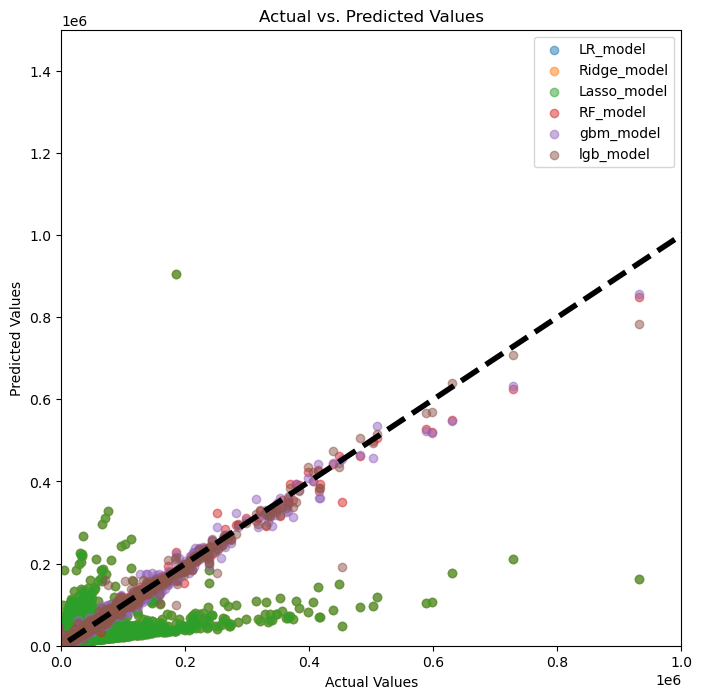

In [131]:
fig, ax = plt.subplots(figsize=(8, 8))


plt.scatter(y_test, y_pred_1, alpha=0.5, label='LR_model')
plt.scatter(y_test, y_pred_2, alpha=0.5, label='Ridge_model')
plt.scatter(y_test, y_pred_3, alpha=0.5, label='Lasso_model')
plt.scatter(y_test, y_pred_4, alpha=0.5, label='RF_model')
plt.scatter(y_test, y_pred_5, alpha=0.5, label='gbm_model')
plt.scatter(y_test, y_pred_6, alpha=0.5, label='lgb_model')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

plt.xlim(0, 1000000)
plt.ylim(0, 1500000)

plt.show()

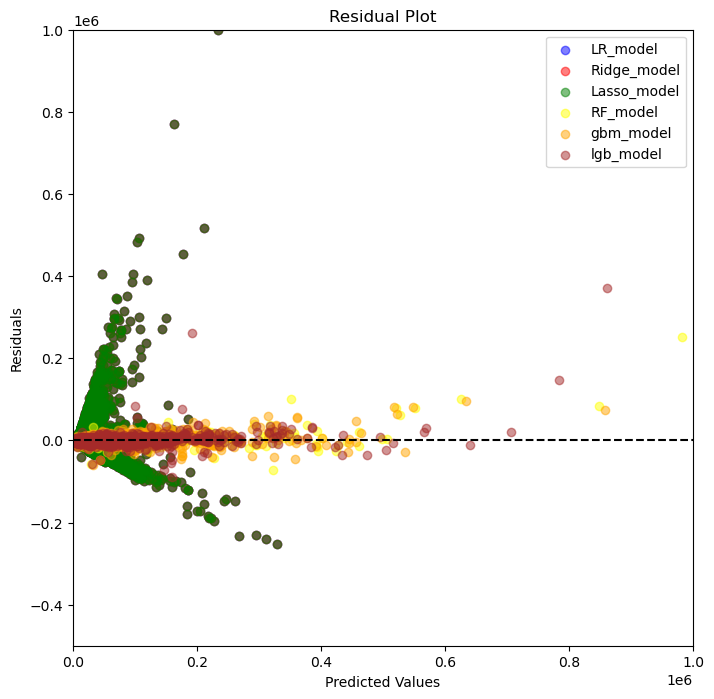

In [132]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(y_pred_1, y_test - y_pred_1, alpha=0.5, label='LR_model', color='blue')
plt.scatter(y_pred_2, y_test - y_pred_2, alpha=0.5, label='Ridge_model', color='red')
plt.scatter(y_pred_3, y_test - y_pred_3, alpha=0.5, label='Lasso_model', color='green')
plt.scatter(y_pred_4, y_test - y_pred_4, alpha=0.5, label='RF_model', color='yellow')
plt.scatter(y_pred_5, y_test - y_pred_5, alpha=0.5, label='gbm_model', color='orange')
plt.scatter(y_pred_6, y_test - y_pred_6, alpha=0.5, label='lgb_model', color='brown')

plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='black', linestyle='dashed')
plt.legend()

plt.xlim(0, 1000000)
plt.ylim(-500000, 1000000)

plt.show()

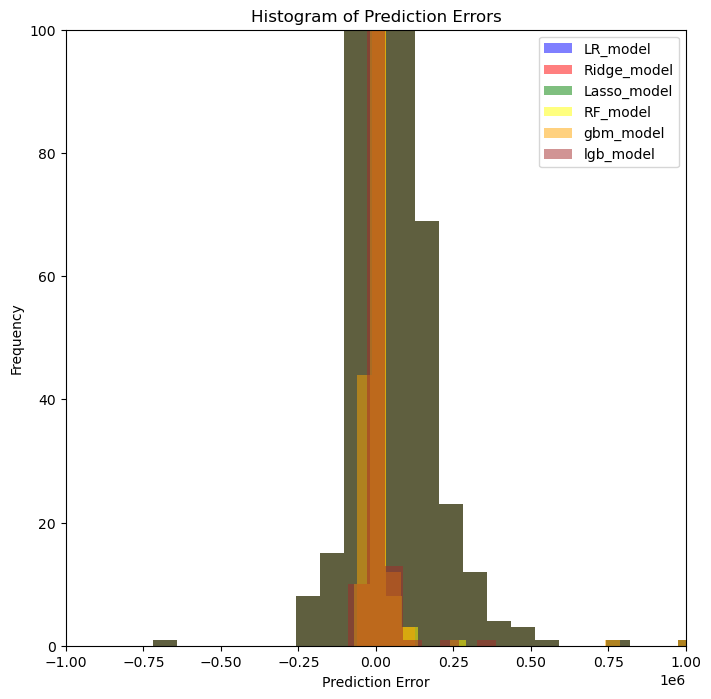

In [133]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.hist(y_test - y_pred_1, bins=50, alpha=0.5, label='LR_model', color='blue')
plt.hist(y_test - y_pred_2, bins=50, alpha=0.5, label='Ridge_model', color='red')
plt.hist(y_test - y_pred_3, bins=50, alpha=0.5, label='Lasso_model', color='green')
plt.hist(y_test - y_pred_4, bins=50, alpha=0.5, label='RF_model', color='yellow')
plt.hist(y_test - y_pred_5, bins=50, alpha=0.5, label='gbm_model', color='orange')
plt.hist(y_test - y_pred_6, bins=50, alpha=0.5, label='lgb_model', color='brown')

plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.legend()

plt.xlim(-1000000, 1000000)
plt.ylim(0, 100)

plt.show()

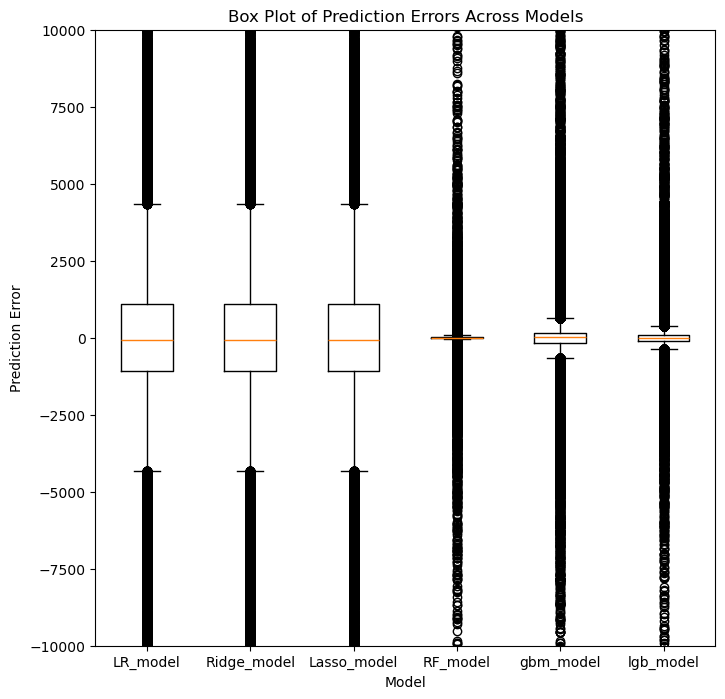

In [134]:
errors = [y_test - y_pred_1, y_test - y_pred_2, y_test - y_pred_3, y_test - y_pred_4, y_test - y_pred_5, y_test - y_pred_6]  # list of errors from different models
fig, ax = plt.subplots(figsize=(8, 8))

plt.boxplot(errors, labels=['LR_model', 'Ridge_model', 'Lasso_model', 'RF_model', 'gbm_model', 'lgb_model'])
plt.xlabel('Model')
plt.ylabel('Prediction Error')
plt.title('Box Plot of Prediction Errors Across Models')

plt.ylim(-10000, 10000)

plt.show()

### 10.0 Simulación de predicción del modelo gbm 

In [295]:
import pickle

# Save the model to disk
filename = 'gbm_model.sav'
pickle.dump(gbm_model, open(filename, 'wb'))

print("Model saved successfully!")

Model saved successfully!


In [304]:
# Number of samples you want to generate
n_samples = 9999

# Generate random data
# Assume the ranges are based on observed ranges in your original dataset
np.random.seed(42)
precio_x = np.random.uniform(low=5, high=20000, size=n_samples)
piezas_y = np.random.randint(low=0, high=2000, size=n_samples)
año = np.random.randint(low=2024, high=2030, size=n_samples)
mes = np.random.randint(low=1, high=12, size=n_samples)
familias = np.random.randint(low=1, high=3, size=n_samples)
divisiones = np.random.randint(low=1, high=5, size=n_samples)
regiones = np.random.randint(low=1, high=18, size=n_samples)
territorios = np.random.randint(low=1, high=100, size=n_samples)
cuentas = np.random.randint(low=1, high=3400, size=n_samples)
sku = np.random.randint(low=1, high=900,  size=n_samples)

# Create a DataFrame
test_data = pd.DataFrame({
    'sku' : sku, 
    'precio_x': precio_x,
    'familias': familias,
    'divisiones': divisiones,
    'regiones' : regiones,
    'territorios' : territorios,
    'cuentas' : cuentas,
    'piezas_y': piezas_y,
    'año': año,
    'mes': mes   
      
})

print(test_data)

      sku      precio_x  familias  divisiones  regiones  territorios  cuentas  \
0     307   7493.929676         2           4         4            3     2887   
1     248  19014.532557         1           2        17           51     3195   
2     294  14641.218867         2           2         8           99     2482   
3     554  11975.176392         2           3        16           67     2011   
4     173   3124.592716         1           4         1           80     1426   
...   ...           ...       ...         ...       ...          ...      ...   
9994  751   2496.661083         1           3        16           44     1191   
9995  219  17153.831485         1           4        17            4     2849   
9996  371  17950.689158         2           4         3           96     1101   
9997   52  18934.424761         2           1         7           77     1401   
9998  199   7952.772408         1           4         5           24     1768   

      piezas_y   año  mes  

In [297]:
filename = 'gbm_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [298]:
predictions = loaded_model.predict(test_data)
print("Predictions:", predictions)

Predictions: [1545775.28936126 1787069.05880226 1415209.770873   ... 1437999.17489772
  321586.88774373 1150840.28117019]


In [299]:
test_data['predictions'] = predictions

In [300]:
test_data

,sku,precio_x,familias,divisiones,regiones,territorios,cuentas,piezas_y,año,mes,predictions
0,173,7493.929676,2,3,16,67,2011,1206,2028,4,1.545775e+06
1,30,19014.532557,2,1,1,80,1426,863,2025,3,1.787069e+06
2,163,14641.218867,1,1,10,57,668,547,2025,1,1.415210e+06
3,28,11975.176392,1,2,7,20,1437,1905,2028,3,1.876657e+06
4,425,3124.592716,2,3,15,45,2377,1060,2024,4,1.301746e+06
...,...,...,...,...,...,...,...,...,...,...,...
9995,466,17153.831485,2,1,5,24,1768,1621,2025,7,1.728623e+06
9996,804,17950.689158,1,3,3,71,2355,1308,2029,8,1.781002e+06
9997,792,18934.424761,2,4,12,19,3320,571,2029,5,1.437999e+06
9998,501,7952.772408,2,4,9,91,294,53,2024,10,3.215869e+05


In [301]:
#encoder = OrdinalEncoder()
#data= test_data

# Fitting the encoder and transforming the data
#encoded_data = encoder.fit_transform(data)

# Creating an encoded DataFrame (just for demonstration)
#encoded_df = pd.DataFrame(encoded_data, columns=data.columns)

# Now to revert the entire DataFrame back to original categories
#decoded_df = pd.DataFrame(encoder.inverse_transform(encoded_df), columns=encoded_df.columns)

In [302]:
pivot_test_data = test_data.pivot_table(values='predictions', columns = 'divisiones', index = ['año'], aggfunc = 'sum').reset_index()
pivot_test_venta = pd.DataFrame(test_data.groupby('año')['predictions'].sum().reset_index())

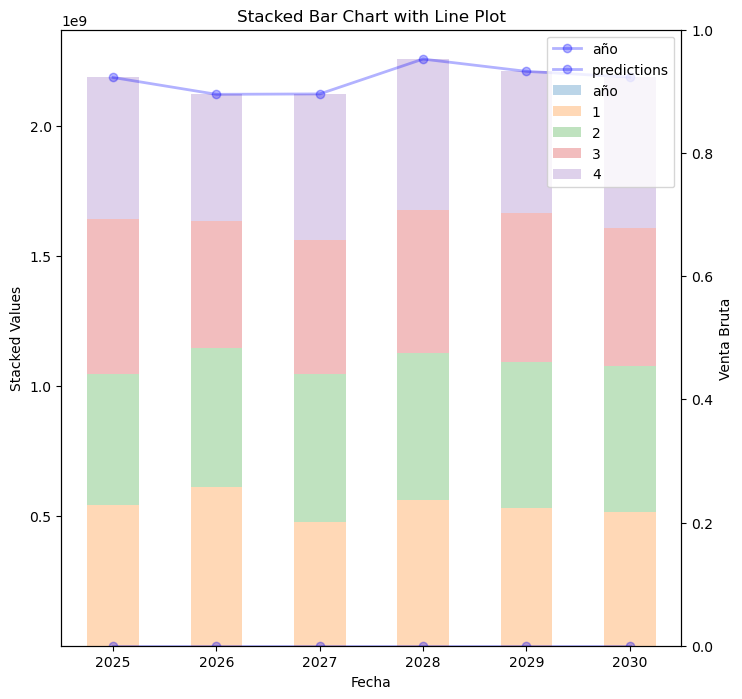

In [308]:
fig, ax1 = plt.subplots(figsize=(8, 8))


pivot_test_data.plot(ax=ax1, kind='bar', stacked=True,  alpha=0.3)
ax2 = ax1.twinx()
pivot_test_venta.plot(ax=ax1, color='blue', marker='o', linewidth=2, label='Suma Venta Bruta', alpha=0.3)

# Set y-axis limits for the secondary axis
#min_y = df_sell_in['venta_bruta'].min() * 0.8  # For example, 80% of the minimum value
#max_y = df_sell_in['venta_bruta'].max() * 1.2  # 120% of the maximum value
#ax2.set_ylim([min_y, max_y])

ax1.set_xlabel('Fecha')
ax1.set_ylabel('Stacked Values')
ax2.set_ylabel('Venta Bruta')

plt.title('Stacked Bar Chart with Line Plot')
ax1.legend(loc='upper right')


ax1.set_xticklabels(labels = ['2025', '2026', '2027', '2028', '2029', '2030'])

plt.show()